In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from scipy import spatial

# Change this according to your directory preferred setting
path_to_train = "../train_sample/train_100_events"

In [17]:

event_prefix = "event000001000"

In [18]:
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [19]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [21]:
model = Clusterer(eps=0.008)
labels = model.predict(hits)

In [22]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [23]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [24]:
print("Your score: ", score)

Your score:  0.1988556913647304


In [25]:
load_dataset(path_to_train, skip=1000, nevents=5)

<generator object load_dataset at 0x00000238B1794200>

In [26]:
dataset_submissions = []
dataset_scores = []

for event_id, hits, cells, particles, truth in load_dataset(path_to_train, skip=0, nevents=5):
        
    # Track pattern recognition
    model = Clusterer(eps=0.008)
    labels = model.predict(hits)
        
    # Prepare submission for an event
    one_submission = create_one_event_submission(event_id, hits, labels)
    dataset_submissions.append(one_submission)
    
    # Score for the event
    score = score_event(truth, one_submission)
    dataset_scores.append(score)
    
    print("Score for event %d: %.3f" % (event_id, score))
    
print('Mean score: %.3f' % (np.mean(dataset_scores)))

Score for event 1000: 0.199
Score for event 1001: 0.204
Score for event 1002: 0.183
Score for event 1003: 0.213
Score for event 1004: 0.195
Mean score: 0.199


In [27]:
# function for arranging hits in a track (closest to origin, closest track to previous track, and so on...)
def arrange_track(track_points):
    arranged_track = pd.DataFrame()

    pt = [0, 0, 0]
    kdtree = spatial.KDTree(track_points)
    distance, index = kdtree.query(pt)

    arranged_track = arranged_track.append(track_points.iloc[index])
    track_points = track_points.drop(track_points.index[index]).reset_index(drop=True)

    while not track_points.empty:
        pt = arranged_track.iloc[-1]
        kdtree = spatial.KDTree(track_points)
        distance, index = kdtree.query(pt)

        arranged_track = arranged_track.append(track_points.iloc[index])
        track_points = track_points.drop(track_points.index[index]).reset_index(drop=True)
        
    return arranged_track

test_points = pd.DataFrame([[0, 0, 5], [0, 0, 1], [0, 0, 3], [0, 0, 2]])
arrange_track(test_points)

,0,1,2
1,0.0,0.0,1.0
2,0.0,0.0,2.0
1,0.0,0.0,3.0
0,0.0,0.0,5.0


In [28]:
# DBSCAN benchmark preprocessing / coordinate transformation
x = hits.x.values
y = hits.y.values
z = hits.z.values

r = np.sqrt(x**2 + y**2 + z**2)
hits['x2'] = x/r
hits['y2'] = y/r

r = np.sqrt(x**2 + y**2)
hits['z2'] = z/r

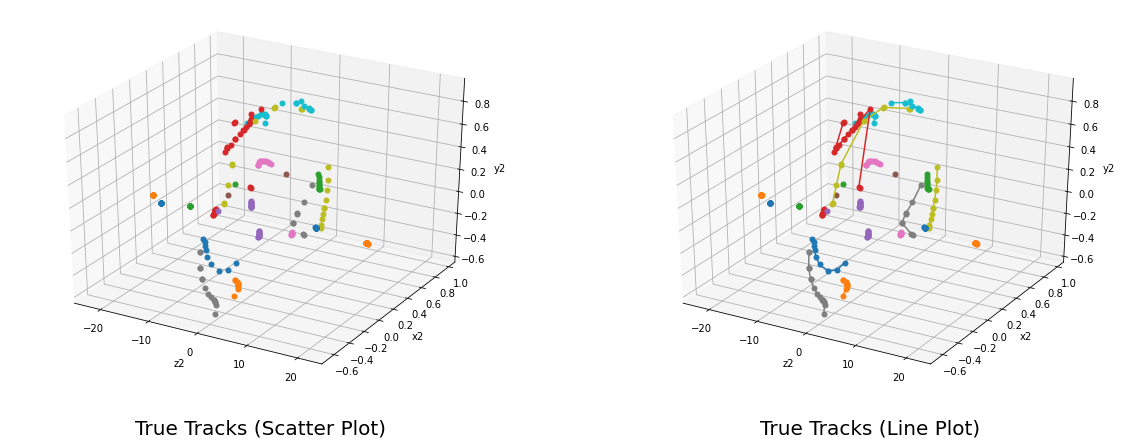

In [29]:
tracks = truth.particle_id.unique()[1::500]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x2', 'y2', 'z2']]
    ax.plot3D(t.z2, t.x2, t.y2, '.', ms=10)
    
ax.set_xlabel('z2')
ax.set_ylabel('x2')
ax.set_zlabel('y2')
ax.set_title("True Tracks (Scatter Plot)", y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x2', 'y2', 'z2']]
    t = arrange_track(t)
    ax2.plot3D(t.z2, t.x2, t.y2, '.-', ms=10)
    
ax2.set_xlabel('z2')
ax2.set_ylabel('x2')
ax2.set_zlabel('y2')
ax2.set_title("True Tracks (Line Plot)", y=-.15, size=20)

plt.show()

In [30]:
X = hits[['x2', 'y2', 'z2']]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

eps = 0.008
min_samp = 1
db = DBSCAN(eps=eps, min_samples=min_samp, metric='euclidean').fit(X)
labels = db.labels_

clustering = pd.DataFrame()
clustering['hit_id'] = truth['hit_id']
clustering['track_id'] = labels

score = score_event(truth, clustering)
print('track-ml custom metric score:', round(score, 4))

labels_true = truth['particle_id']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('\nOTHER CLUSTERING RESULTS:')
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
rej_perc = list(labels).count(-1) / float(hits.shape[0]) * 100
rej_perc = round(rej_perc, 2)
print ("Rejected samples %:", str(rej_perc) + '%')
rejected_count = list(labels).count(-1)
print ("Rejected samples:", rejected_count)
print ("Total samples:", hits.shape[0])
print ("Clustered samples:", hits.shape[0] - list(labels).count(-1))

track-ml custom metric score: 0.1951

OTHER CLUSTERING RESULTS:
Estimated number of clusters: 69912
Homogeneity: 0.951
Completeness: 0.758
Adjusted Rand Index: 0.002
Rejected samples %: 0.0%
Rejected samples: 0
Total samples: 138568
Clustered samples: 138568


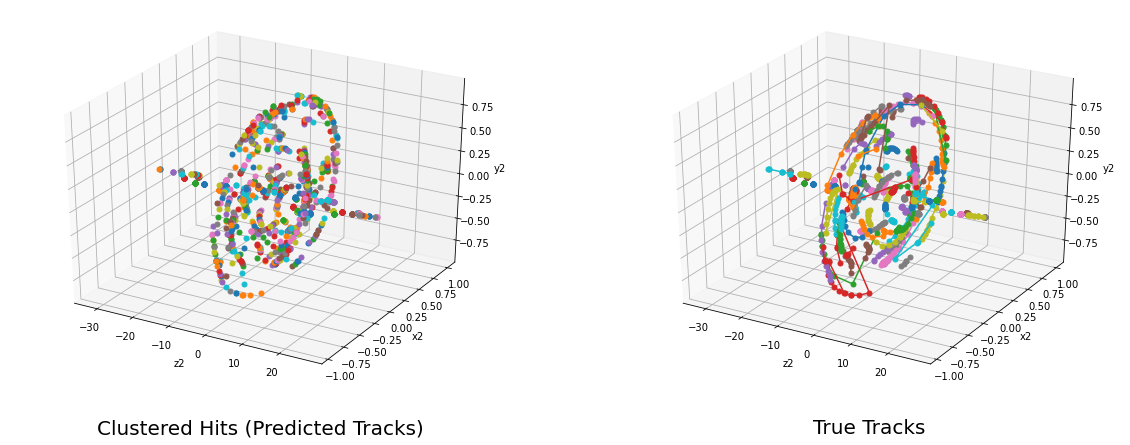

In [31]:
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')

tracks_hit_ids = truth[truth['particle_id'].isin(tracks)]['hit_id'] # all hits in tracks
clusters = clustering[clustering['hit_id'].isin(tracks_hit_ids)].track_id.unique() # all clusters containing the hits in tracks
for cluster in clusters:
    cluster_hit_ids = clustering[clustering['track_id'] == cluster]['hit_id'] # all hits in cluster
    plot_hit_ids = list(set(tracks_hit_ids) & set(cluster_hit_ids))
    t = hits[hits['hit_id'].isin(plot_hit_ids)][['x2', 'y2', 'z2']]
    if cluster == -1:
        ax.plot3D(t.z2, t.x2, t.y2, '.', ms=10, color='black')
    else:
        ax.plot3D(t.z2, t.x2, t.y2, '.-', ms=10)
    
ax.set_xlabel('z2')
ax.set_ylabel('x2')
ax.set_zlabel('y2')
ax.set_title('Clustered Hits (Predicted Tracks)', y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x2', 'y2', 'z2']]
    t = arrange_track(t)
    ax2.plot3D(t.z2, t.x2, t.y2, '.-', ms=10)
    
ax2.set_xlabel('z2')
ax2.set_ylabel('x2')
ax2.set_zlabel('y2')
ax2.set_title('True Tracks', y=-.15, size=20)

plt.show()

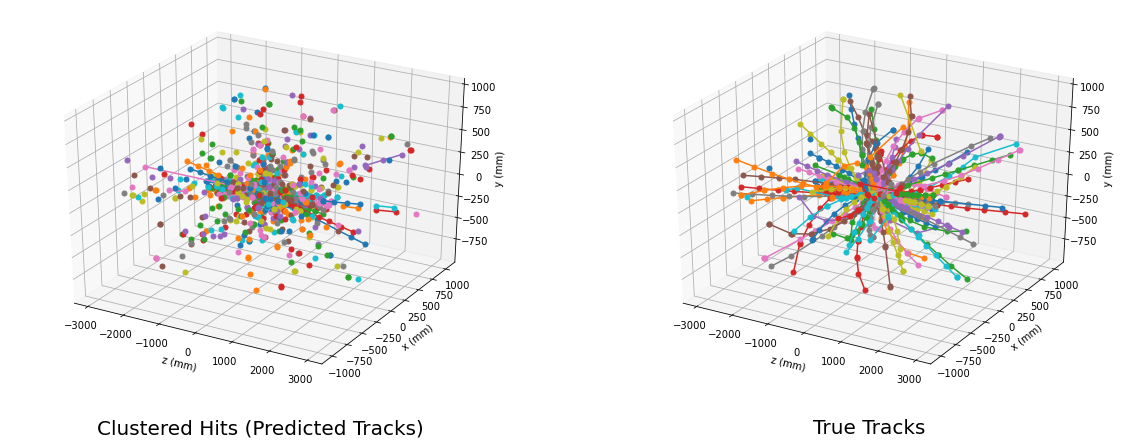

In [32]:
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')

tracks_hit_ids = truth[truth['particle_id'].isin(tracks)]['hit_id'] # all hits in tracks
clusters = clustering[clustering['hit_id'].isin(tracks_hit_ids)].track_id.unique() # all clusters containing the hits in tracks
for cluster in clusters:
    cluster_hit_ids = clustering[clustering['track_id'] == cluster]['hit_id'] # all hits in cluster
    plot_hit_ids = list(set(tracks_hit_ids) & set(cluster_hit_ids))
    t = hits[hits['hit_id'].isin(plot_hit_ids)][['x', 'y', 'z']]
    if cluster == -1:
        ax.plot3D(t.z, t.x, t.y, '.', ms=10, color='black')
    else:
        ax.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title('Clustered Hits (Predicted Tracks)', y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x', 'y', 'z']]
    t = arrange_track(t)
    ax2.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('x (mm)')
ax2.set_zlabel('y (mm)')
ax2.set_title('True Tracks', y=-.15, size=20)

plt.show()

In [ ]:
#Here I try with a higher eps (eps=0.018)
#Increasing the eps means decreasing the density required to form a cluster. 
#eps is the distance that is used to define the neighbors of a sample. 
#Since we increased eps, we expect bigger clusters to be formed.

In [33]:
X = hits[['x2', 'y2', 'z2']]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

eps = 0.018
min_samp = 1
db = DBSCAN(eps=eps, min_samples=min_samp, metric='euclidean').fit(X)
labels = db.labels_

clustering = pd.DataFrame()
clustering['hit_id'] = truth['hit_id']
clustering['track_id'] = labels

score = score_event(truth, clustering)
print('track-ml custom metric score:', round(score, 4))

labels_true = truth['particle_id']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('\nOTHER CLUSTERING RESULTS:')
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
rej_perc = list(labels).count(-1) / float(hits.shape[0]) * 100
rej_perc = round(rej_perc, 2)
print ("Rejected samples %:", str(rej_perc) + '%')
rejected_count = list(labels).count(-1)
print ("Rejected samples:", rejected_count)
print ("Total samples:", hits.shape[0])
print ("Clustered samples:", hits.shape[0] - list(labels).count(-1))

track-ml custom metric score: 0.0644

OTHER CLUSTERING RESULTS:
Estimated number of clusters: 24090
Homogeneity: 0.676
Completeness: 0.748
Adjusted Rand Index: -0.011
Rejected samples %: 0.0%
Rejected samples: 0
Total samples: 138568
Clustered samples: 138568


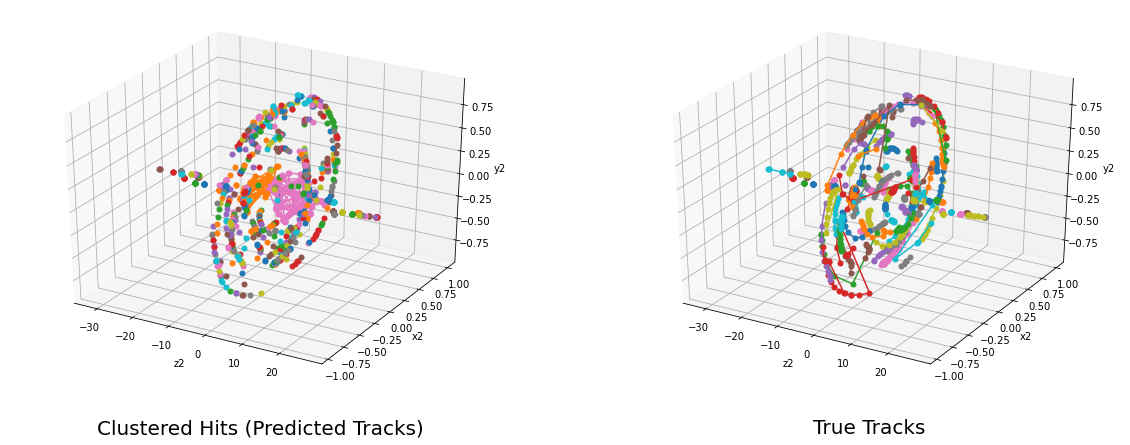

In [34]:
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')

tracks_hit_ids = truth[truth['particle_id'].isin(tracks)]['hit_id'] # all hits in tracks
clusters = clustering[clustering['hit_id'].isin(tracks_hit_ids)].track_id.unique() # all clusters containing the hits in tracks
for cluster in clusters:
    cluster_hit_ids = clustering[clustering['track_id'] == cluster]['hit_id'] # all hits in cluster
    plot_hit_ids = list(set(tracks_hit_ids) & set(cluster_hit_ids))
    t = hits[hits['hit_id'].isin(plot_hit_ids)][['x2', 'y2', 'z2']]
    if cluster == -1:
        ax.plot3D(t.z2, t.x2, t.y2, '.', ms=10, color='black')
    else:
        ax.plot3D(t.z2, t.x2, t.y2, '.-', ms=10)
    
ax.set_xlabel('z2')
ax.set_ylabel('x2')
ax.set_zlabel('y2')
ax.set_title('Clustered Hits (Predicted Tracks)', y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x2', 'y2', 'z2']]
    t = arrange_track(t)
    ax2.plot3D(t.z2, t.x2, t.y2, '.-', ms=10)
    
ax2.set_xlabel('z2')
ax2.set_ylabel('x2')
ax2.set_zlabel('y2')
ax2.set_title('True Tracks', y=-.15, size=20)

plt.show()

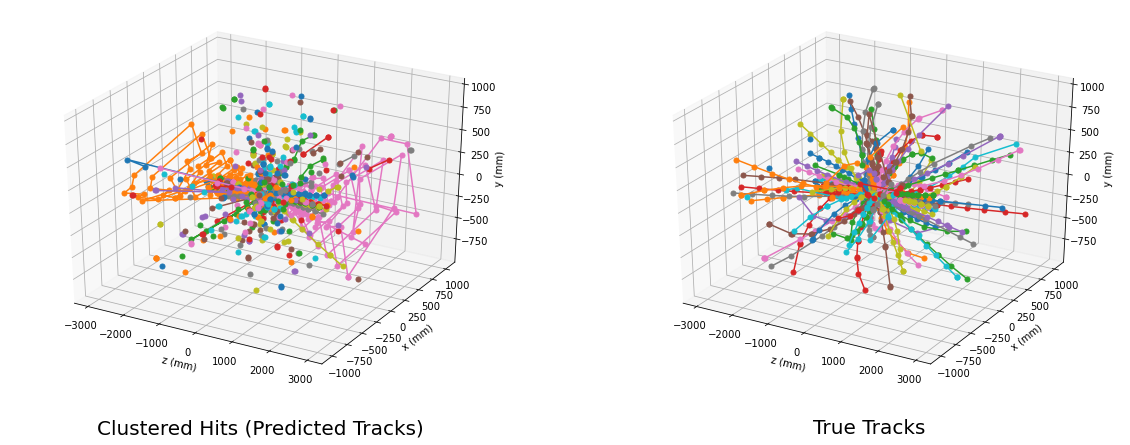

In [35]:
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')

tracks_hit_ids = truth[truth['particle_id'].isin(tracks)]['hit_id'] # all hits in tracks
clusters = clustering[clustering['hit_id'].isin(tracks_hit_ids)].track_id.unique() # all clusters containing the hits in tracks
for cluster in clusters:
    cluster_hit_ids = clustering[clustering['track_id'] == cluster]['hit_id'] # all hits in cluster
    plot_hit_ids = list(set(tracks_hit_ids) & set(cluster_hit_ids))
    t = hits[hits['hit_id'].isin(plot_hit_ids)][['x', 'y', 'z']]
    if cluster == -1:
        ax.plot3D(t.z, t.x, t.y, '.', ms=10, color='black')
    else:
        ax.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title('Clustered Hits (Predicted Tracks)', y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x', 'y', 'z']]
    t = arrange_track(t)
    ax2.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('x (mm)')
ax2.set_zlabel('y (mm)')
ax2.set_title('True Tracks', y=-.15, size=20)

plt.show()

In [ ]:
#now here I try with changing min_scamp=3
#Increasing the minimum samples means decreasing the density required to form a cluster. 
#Let's see the effects of this adjustment to the score and clustering metrics.

In [36]:
X = hits[['x2', 'y2', 'z2']]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

eps = 0.008
min_samp = 3
db = DBSCAN(eps=eps, min_samples=min_samp, metric='euclidean').fit(X)
labels = db.labels_

clustering = pd.DataFrame()
clustering['hit_id'] = truth['hit_id']
clustering['track_id'] = labels

score = score_event(truth, clustering)
print('track-ml custom metric score:', round(score, 4))

labels_true = truth['particle_id']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('\nOTHER CLUSTERING RESULTS:')
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
rej_perc = list(labels).count(-1) / float(hits.shape[0]) * 100
rej_perc = round(rej_perc, 2)
print ("Rejected samples %:", str(rej_perc) + '%')
rejected_count = list(labels).count(-1)
print ("Rejected samples:", rejected_count)
print ("Total samples:", hits.shape[0])
print ("Clustered samples:", hits.shape[0] - list(labels).count(-1), '\n')

print ('WITHOUT REJECTED SAMPLES:')
labels_true_wr = labels_true[labels != -1]
labels_wr = labels[labels != -1]
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true_wr, labels_wr))
print(("Completeness: %0.3f" % metrics.completeness_score(labels_true_wr, labels_wr)), '\n')

track-ml custom metric score: 0.1951

OTHER CLUSTERING RESULTS:
Estimated number of clusters: 9471
Homogeneity: 0.479
Completeness: 0.835
Adjusted Rand Index: 0.043
Rejected samples %: 52.73%
Rejected samples: 73064
Total samples: 138568
Clustered samples: 65504 

WITHOUT REJECTED SAMPLES:
Homogeneity: 0.915
Completeness: 0.897 



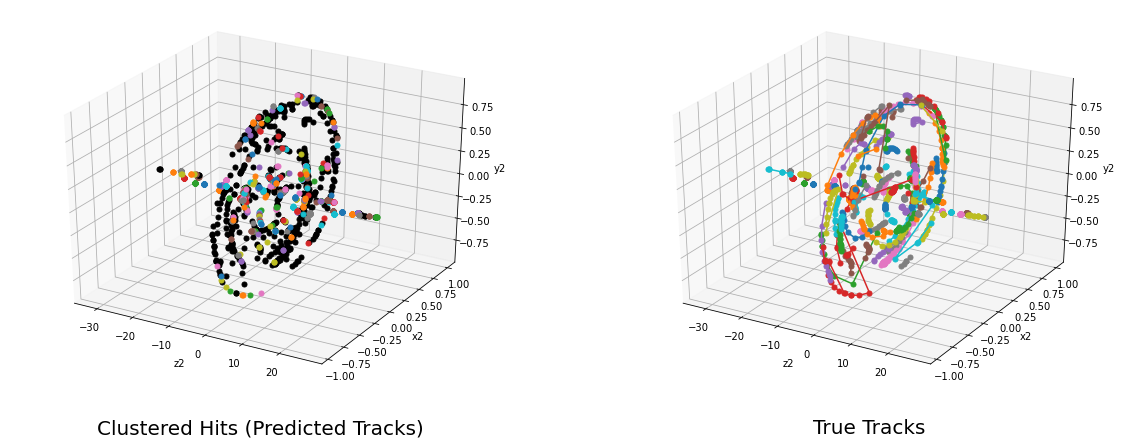

In [37]:
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')

tracks_hit_ids = truth[truth['particle_id'].isin(tracks)]['hit_id'] # all hits in tracks
clusters = clustering[clustering['hit_id'].isin(tracks_hit_ids)].track_id.unique() # all clusters containing the hits in tracks
for cluster in clusters:
    cluster_hit_ids = clustering[clustering['track_id'] == cluster]['hit_id'] # all hits in cluster
    plot_hit_ids = list(set(tracks_hit_ids) & set(cluster_hit_ids))
    t = hits[hits['hit_id'].isin(plot_hit_ids)][['x2', 'y2', 'z2']]
    if cluster == -1:
        ax.plot3D(t.z2, t.x2, t.y2, '.', ms=10, color='black')
    else:
        ax.plot3D(t.z2, t.x2, t.y2, '.-', ms=10)
    
ax.set_xlabel('z2')
ax.set_ylabel('x2')
ax.set_zlabel('y2')
ax.set_title('Clustered Hits (Predicted Tracks)', y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x2', 'y2', 'z2']]
    t = arrange_track(t)
    ax2.plot3D(t.z2, t.x2, t.y2, '.-', ms=10)
    
ax2.set_xlabel('z2')
ax2.set_ylabel('x2')
ax2.set_zlabel('y2')
ax2.set_title('True Tracks', y=-.15, size=20)

plt.show()

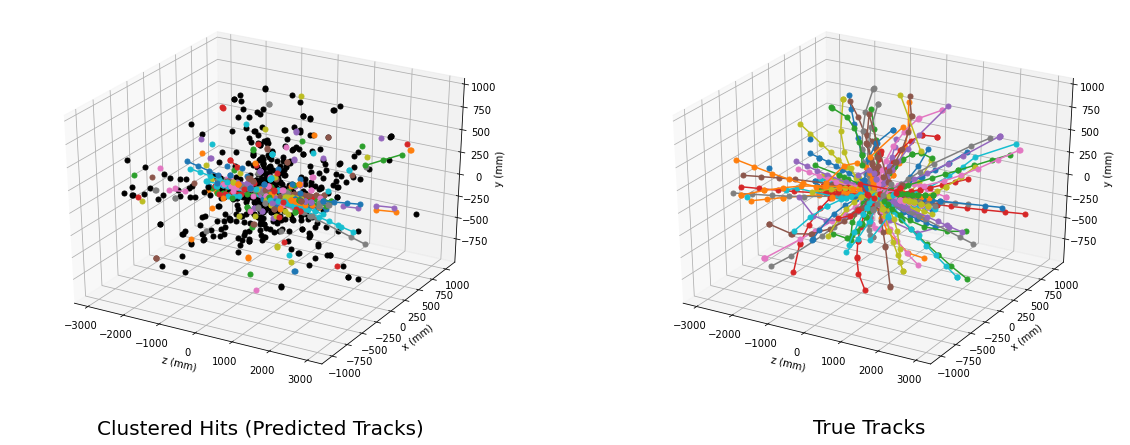

In [38]:
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')

tracks_hit_ids = truth[truth['particle_id'].isin(tracks)]['hit_id'] # all hits in tracks
clusters = clustering[clustering['hit_id'].isin(tracks_hit_ids)].track_id.unique() # all clusters containing the hits in tracks
for cluster in clusters:
    cluster_hit_ids = clustering[clustering['track_id'] == cluster]['hit_id'] # all hits in cluster
    plot_hit_ids = list(set(tracks_hit_ids) & set(cluster_hit_ids))
    t = hits[hits['hit_id'].isin(plot_hit_ids)][['x', 'y', 'z']]
    if cluster == -1:
        ax.plot3D(t.z, t.x, t.y, '.', ms=10, color='black')
    else:
        ax.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title('Clustered Hits (Predicted Tracks)', y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x', 'y', 'z']]
    t = arrange_track(t)
    ax2.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('x (mm)')
ax2.set_zlabel('y (mm)')
ax2.set_title('True Tracks', y=-.15, size=20)

plt.show()

In [ ]:
# and here we have scaling and normalization with no coordinate transformation

In [39]:
X = hits[['x', 'y', 'z']]
scaler = MaxAbsScaler().fit(X)
X = scaler.transform(X)
normalizer = Normalizer(norm='l2').fit(X)
X = normalizer.transform(X)

eps = 0.0022
min_samp = 3
db = DBSCAN(eps=eps, min_samples=min_samp, metric='euclidean').fit(X)
labels = db.labels_

clustering = pd.DataFrame()
clustering['hit_id'] = truth['hit_id']
clustering['track_id'] = labels

score = score_event(truth, clustering)
print('track-ml custom metric score:', round(score, 4))

labels_true = truth['particle_id']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('\nOTHER CLUSTERING RESULTS:')
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
rej_perc = list(labels).count(-1) / float(hits.shape[0]) * 100
rej_perc = round(rej_perc, 2)
print ("Rejected samples %:", str(rej_perc) + '%')
rejected_count = list(labels).count(-1)
print ("Rejected samples:", rejected_count)
print ("Total samples:", hits.shape[0])
print ("Clustered samples:", hits.shape[0] - list(labels).count(-1), '\n')

print ('WITHOUT REJECTED SAMPLES:')
labels_true_wr = labels_true[labels != -1]
labels_wr = labels[labels != -1]
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true_wr, labels_wr))
print(("Completeness: %0.3f" % metrics.completeness_score(labels_true_wr, labels_wr)), '\n')

track-ml custom metric score: 0.1481

OTHER CLUSTERING RESULTS:
Estimated number of clusters: 4477
Homogeneity: 0.263
Completeness: 0.900
Adjusted Rand Index: 0.020
Rejected samples %: 76.15%
Rejected samples: 105521
Total samples: 138568
Clustered samples: 33047 

WITHOUT REJECTED SAMPLES:
Homogeneity: 0.951
Completeness: 0.966 



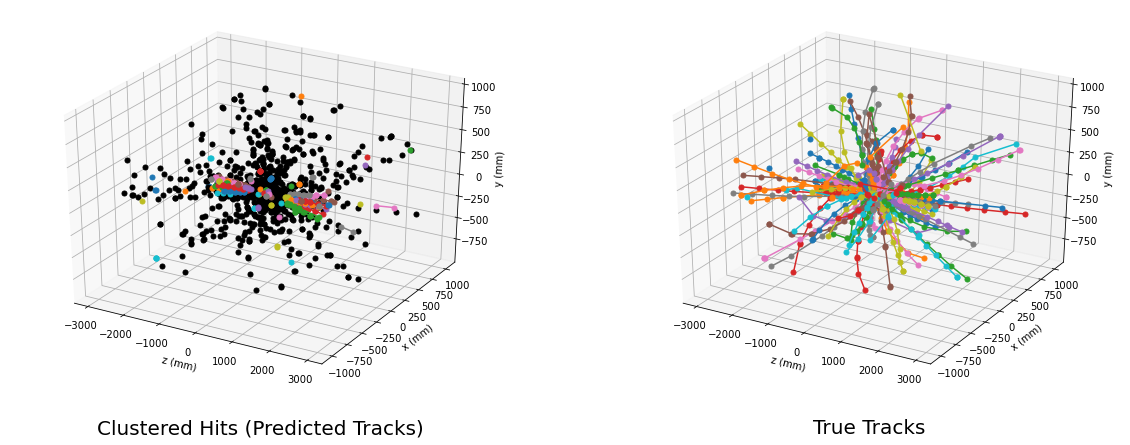

In [40]:
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')

tracks_hit_ids = truth[truth['particle_id'].isin(tracks)]['hit_id'] # all hits in tracks
clusters = clustering[clustering['hit_id'].isin(tracks_hit_ids)].track_id.unique() # all clusters containing the hits in tracks
for cluster in clusters:
    cluster_hit_ids = clustering[clustering['track_id'] == cluster]['hit_id'] # all hits in cluster
    plot_hit_ids = list(set(tracks_hit_ids) & set(cluster_hit_ids))
    t = hits[hits['hit_id'].isin(plot_hit_ids)][['x', 'y', 'z']]
    if cluster == -1:
        ax.plot3D(t.z, t.x, t.y, '.', ms=10, color='black')
    else:
        ax.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title('Clustered Hits (Predicted Tracks)', y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x', 'y', 'z']]
    t = arrange_track(t)
    ax2.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('x (mm)')
ax2.set_zlabel('y (mm)')
ax2.set_title('True Tracks', y=-.15, size=20)

plt.show()

In [47]:
# k means
from sklearn.cluster import KMeans

random_state=42
n_clusters=15

In [48]:
X = hits[['x2', 'y2', 'z2']]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

eps = 0.008
min_samp = 1
db = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
labels = db.labels_

clustering = pd.DataFrame()
clustering['hit_id'] = truth['hit_id']
clustering['track_id'] = labels

score = score_event(truth, clustering)
print('track-ml custom metric score:', round(score, 4))

labels_true = truth['particle_id']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('\nOTHER CLUSTERING RESULTS:')
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
rej_perc = list(labels).count(-1) / float(hits.shape[0]) * 100
rej_perc = round(rej_perc, 2)
print ("Rejected samples %:", str(rej_perc) + '%')
rejected_count = list(labels).count(-1)
print ("Rejected samples:", rejected_count)
print ("Total samples:", hits.shape[0])
print ("Clustered samples:", hits.shape[0] - list(labels).count(-1))

track-ml custom metric score: 0.0

OTHER CLUSTERING RESULTS:
Estimated number of clusters: 15
Homogeneity: 0.245
Completeness: 0.787
Adjusted Rand Index: 0.000
Rejected samples %: 0.0%
Rejected samples: 0
Total samples: 138568
Clustered samples: 138568


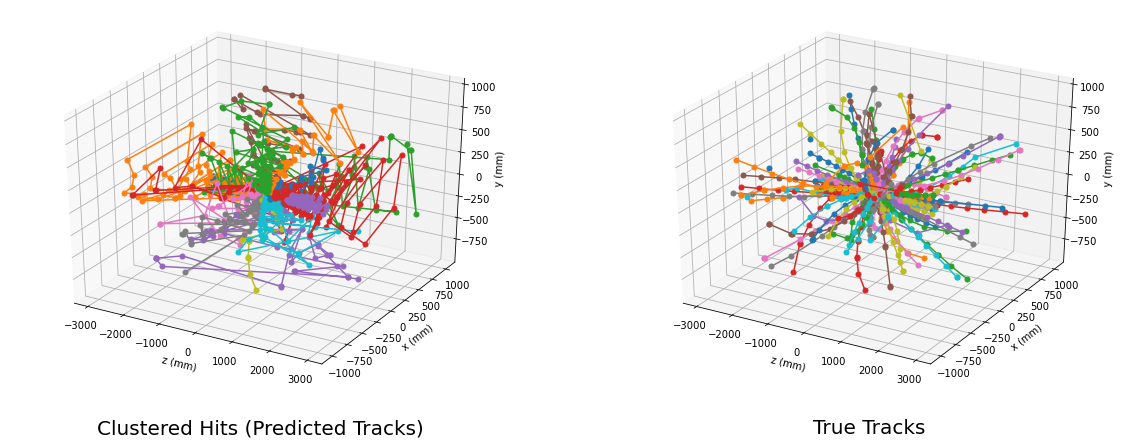

In [49]:
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax = fig.add_subplot(121,projection='3d')

tracks_hit_ids = truth[truth['particle_id'].isin(tracks)]['hit_id'] # all hits in tracks
clusters = clustering[clustering['hit_id'].isin(tracks_hit_ids)].track_id.unique() # all clusters containing the hits in tracks
for cluster in clusters:
    cluster_hit_ids = clustering[clustering['track_id'] == cluster]['hit_id'] # all hits in cluster
    plot_hit_ids = list(set(tracks_hit_ids) & set(cluster_hit_ids))
    t = hits[hits['hit_id'].isin(plot_hit_ids)][['x', 'y', 'z']]
    if cluster == -1:
        ax.plot3D(t.z, t.x, t.y, '.', ms=10, color='black')
    else:
        ax.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title('Clustered Hits (Predicted Tracks)', y=-.15, size=20)

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x', 'y', 'z']]
    t = arrange_track(t)
    ax2.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('x (mm)')
ax2.set_zlabel('y (mm)')
ax2.set_title('True Tracks', y=-.15, size=20)

plt.show()

In [60]:
!conda install cython
!conda install numpy scipy
!conda install scikit-learn
!pip install hdbscan

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

  Using cached hdbscan-0.8.26.tar.gz (4.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for hdbscan: filename=hdbscan-0.8.26-cp38-cp38-win_amd64.whl size=635828 sha256=9d02b27b6253a044cb54e50dfa9f72db5ee2753f99524d67e29915b699b9dbda
  Stored in directory: c:\users\filli\appdata\local\pip\cache\wheels\eb\81\cf\9a05377f03cf1b5b057841c6ba5deac8b9926630c6bcd423e5
Successfully built hdbscan


In [62]:
#!pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan

In [61]:
from sklearn.datasets import make_blobs
import hdbscan

In [ ]:
X = hits[['x2', 'y2', 'z2']]
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

eps = 0.008
min_samp = 1
db = hdbscan.HDBSCAN(min_samples=1,min_cluster_size=7,cluster_selection_method='leaf',metric='braycurtis').fit(X)
labels = db.labels_

clustering = pd.DataFrame()
clustering['hit_id'] = truth['hit_id']
clustering['track_id'] = labels

score = score_event(truth, clustering)
print('track-ml custom metric score:', round(score, 4))

labels_true = truth['particle_id']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print('\nOTHER CLUSTERING RESULTS:')
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
rej_perc = list(labels).count(-1) / float(hits.shape[0]) * 100
rej_perc = round(rej_perc, 2)
print ("Rejected samples %:", str(rej_perc) + '%')
rejected_count = list(labels).count(-1)
print ("Rejected samples:", rejected_count)
print ("Total samples:", hits.shape[0])
print ("Clustered samples:", hits.shape[0] - list(labels).count(-1))